In [88]:
import pandas as pd
import numpy as np
import seaborn as sns 
from collections import Counter, defaultdict
from nltk.tokenize import WordPunctTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import gensim.downloader
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import BertTokenizer, BertModel
from tqdm.notebook import tqdm
import random
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import KFold

In [3]:
train_data = pd.read_csv('/kaggle/input/vk-contest-dataset/train_spam.csv')
test_data = pd.read_csv('/kaggle/input/vk-contest-dataset/test_spam.csv')

In [4]:
train_data.head(3)

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...


In [5]:
test_data.head(3)

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...


### 1. Basic analysis

Поскольку в данном случае данные довольно простые, то базовые вещи, на которые стоит посмотреть при анализе, это соотношение спамовых и не спамовых сообщений и часто встречающиеся слова в зависимости от типа сообщения.

In [6]:
train_data.text_type.value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

In [7]:
spam_text = list(train_data[train_data['text_type']=='spam']['text'].values)
non_spam_text = list(train_data[train_data['text_type']=='ham']['text'].values)

In [8]:
spam_text[0], non_spam_text[0]

('plzz visit my website moviesgodml to get all movies for free and also i provide direct download links no redirect and ads😊😊😊😊😁',
 'make sure alex knows his birthday is over in fifteen minutes as far as youre concerned')

In [9]:
# Приводим к строки к удобному формату (нижний ригистр и пробелы между словами)
tokenizer = WordPunctTokenizer()
process = lambda s: ' '.join(tokenizer.tokenize(s.lower()))

spam_text_prcd = list(map(process, spam_text))
non_spam_text_prcd = list(map(process, non_spam_text))

In [10]:
spam_text_prcd[0], non_spam_text_prcd[0]

('plzz visit my website moviesgodml to get all movies for free and also i provide direct download links no redirect and ads 😊😊😊😊😁',
 'make sure alex knows his birthday is over in fifteen minutes as far as youre concerned')

In [11]:
spam_counter = dict()
non_spam_counter = dict()

for line in list(map(lambda s : s.split(), spam_text_prcd)):
    cur_len = len(line)
    for i in range(cur_len):
        spam_counter.setdefault(line[i], 0)
        spam_counter[line[i]] += 1
        
    
for line in list(map(lambda s : s.split(), non_spam_text_prcd)):
    cur_len = len(line)
    for i in range(cur_len):
        non_spam_counter.setdefault(line[i], 0)
        non_spam_counter[line[i]] += 1

In [12]:
# Сортируем по количеству вхождений слов

spam_counter_lst = list(spam_counter.items())
non_spam_counter_lst = list(non_spam_counter.items())

spam_counter_lst_sort = sorted(spam_counter_lst, key = lambda x: -x[1])
non_spam_counter_lst_sort = sorted(non_spam_counter_lst, key=lambda x: -x[1])

In [13]:
texts = list(map(process, list(train_data.text.values)))

In [14]:
texts_processed = list(map(str.split, texts))

(array([8.857e+03, 1.986e+03, 1.289e+03, 3.667e+03, 4.700e+02, 4.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 2.000e+00]),
 array([  1. ,  38.1,  75.2, 112.3, 149.4, 186.5, 223.6, 260.7, 297.8,
        334.9, 372. ]),
 <BarContainer object of 10 artists>)

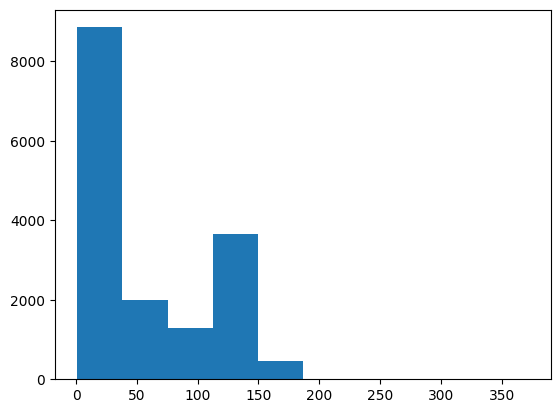

In [15]:
# Посмотрим на распределение длин сообщений, длина - количество слов в сообщении
lens = list(map(len, texts_processed))
plt.hist(lens)

In [19]:
np.percentile(lens, 75)

115.0

### Approach 1: TF-IDF features

Для простоты возьмём 3000 наиболее распространненых слов и на их основе построим tf-idf признаки, затем над этими признаками построим модель.

In [15]:
all_text = spam_text + non_spam_text
word_to_count = dict()

for mesg in all_text:
    curr_dct = dict(Counter(mesg.split()))
    for key in curr_dct.keys():
        if key in word_to_count:
            word_to_count[key] += curr_dct[key]
        else:
            word_to_count[key] = curr_dct[key]
            
sorted_dct = dict(sorted(word_to_count.items(), key=lambda x: -x[1]))
bow_vocabulary = list(sorted_dct.keys())[:3000]

In [16]:
def text_to_bow(text):
    '''
    Convert text string to an array of token counts.
    '''
    counts = []
    for key_word in bow_vocabulary:
        counts.append(text.split().count(key_word))
    return np.array(counts, 'float32')

class TF_IDF_Vectorizer:
    
    smooth = 1
    
    def __init__(self, vocab=bow_vocabulary):
        
        self.vocab = bow_vocabulary
        self.idf = np.zeros(len(self.vocab))
        self.N = 0
    
    def fit(self , X):
        '''
        Count idf for each word in vocab
        
        X: [n_samples, vocab_size] - bow documents representations
        '''
        self.N = X.shape[0]
        freqs = np.apply_along_axis(lambda item: item!=0, axis=0,arr=X).sum(axis=0)
        freqs[freqs==0] = self.smooth
        self.idf = np.log(self.N / freqs)
        
    def process(self, text):
        '''
        Convert string to tf-idf representation.
        '''
        bow_repr = text_to_bow(text)
        return bow_repr * self.idf 

In [23]:
train_data['target']=(train_data['text_type'] == 'ham').apply(lambda x: int(x))
train_data.head(3)

,text_type,text,target
0,ham,make sure alex knows his birthday is over in f...,1
1,ham,a resume for john lavorato thanks vince i will...,1
2,spam,plzz visit my website moviesgodml to get all m...,0


In [24]:
labels = train_data['target']
texts = list(train_data['text'].values)

In [19]:
texts_train, texts_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3,random_state=42)

In [20]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))


KeyboardInterrupt



In [59]:
vectorizer = TF_IDF_Vectorizer()
vectorizer.fit(X_train_bow)

X_train_tfidf = np.vstack(list(map(vectorizer.process, texts_train)))
X_test_tfidf = np.vstack(list(map(vectorizer.process, texts_test)))

In [60]:
X_train_tfidf.shape, X_test_tfidf.shape

((11394, 3000), (4884, 3000))

В качестве модели классификации возьмём логистическую регрессию.

In [62]:
tfidf_model = LogisticRegression()
tfidf_model.fit(X_train_tfidf, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

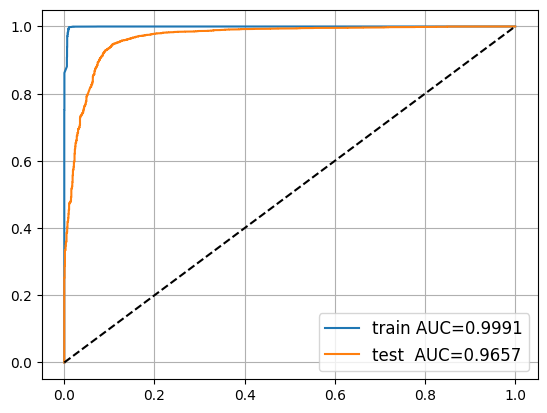

In [75]:
for name, X, y, model in [
    ('train', X_train_tfidf, y_train, tfidf_model),
    ('test ', X_test_tfidf, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Значение метрики получилось достаточно высоким, но данный подход обладает рядом недостатков:
- никак не учитывает общий контекст сообщения
- обращает внимание лишь на отдельно взятые слова.

Возможные улучшения:
- Выбор других моделей(например градиентный бустинг)
- Тюнинг гиперпараметров
- Использование большего числа признаков

### Approach 2: word vectors

Вместо подсчёта tf-idf признаков, возьмём предобуенные эмбеддинги и усредним по ним для каждого слова в сообщение. Получим два очевидных преимущества: Значимо уменьшим число признаков (но это может привести к уменьшению итогового скора, зато ускорит работу модели) и сможем учитывать слова, которых нет в обучающих данных. 

In [83]:
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [37]:
def vectorize_sum(comment):
    '''
    Function  converts comment to a sum of token vectors
    '''
    embedding_dim = 300
    features = np.zeros([embedding_dim], dtype='float32')
    
    for word in comment.split():
        try:
            emb = embeddings.get_vector(word)
        except:
            continue
        features += emb
    
    return features

In [38]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


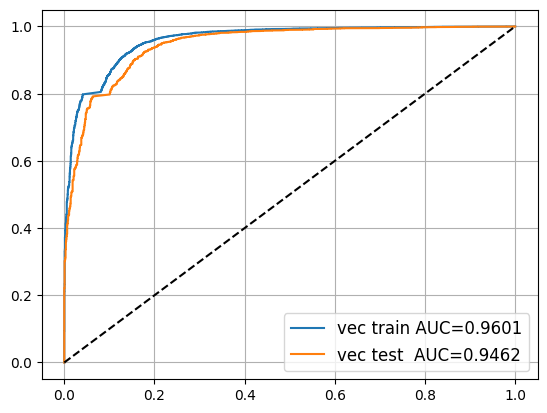

In [87]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Получили более плохой результат по сравнению с предыдущим подходом, но это связано с тем, что усреднять или просто складывать эмбеддинги не самая лучшая идея. 

Возможное улучшение подхода:
- складывать вектора с весами, определяющими значимость слова(like tf-idf).

### Approach 3: BERT features

В данном подходе реализуем следующую идею: возьмём предобученный BERT и прогоним каждое сообщение через него, вектор из последнего сообщения, соответствующий токену cls возьмём в качестве признакового описания сообщения и над полученными признаками построим итоговую модель.
Возможный недостаток данного подхода:
- предобученный BERT генерирует представления, которые неидеально подходят под классификацию спама.
Улучшение:
- тюнинг всего BERT'a под задачу.

In [16]:
class BertFeaturesExtractor:
    
    def __init__(self):
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        
    def get_features(self, msg):
        encoded_input = self.tokenizer(msg,padding=True,truncation=True, return_tensors='pt')
        return self.model(**encoded_input)['last_hidden_state'][:, 0, :]

In [17]:
feature_extractor = BertFeaturesExtractor()

In [18]:
if next(feature_extractor.model.parameters()).is_cuda:
    print("Модель находится на устройстве CUDA")
else:
    print("Модель находится на CPU")

Модель находится на CPU


In [19]:
import gc

bert_ft = None
i = 0
for msg in tqdm(texts):
    with torch.no_grad():
        features = feature_extractor.get_features(msg)
        if bert_ft is None:
            bert_ft = features
        else:
            bert_ft = torch.cat((bert_ft, features), dim=0)
    i += 1
    if i % 500 == 0:
        gc.collect()

  0%|          | 0/16278 [00:00<?, ?it/s]

In [20]:
bert_ft.shape

torch.Size([16278, 768])

In [36]:
torch.save(bert_ft, 'bert_ft.pt')

In [33]:
bert_ft_np = np.array(bert_ft)
labels_np = np.array(labels)

bert_train_ft, bert_test_ft, y_train, y_test = train_test_split(bert_ft_np, labels_np, test_size=0.3,random_state=42)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


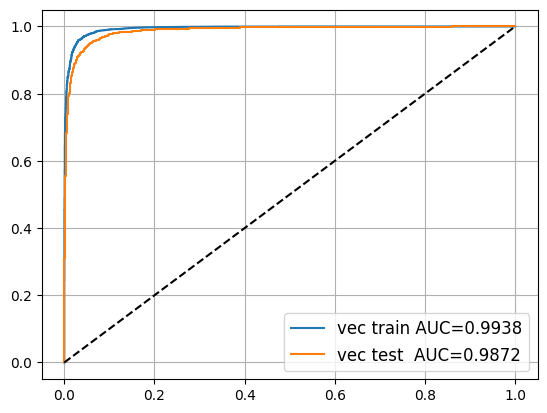

In [34]:
# Попробуем опять же самую простую линейную регрессию для данных признаков
lr_model_on_bert = LogisticRegression().fit(bert_train_ft, y_train)

for name, X, y, model in [
    ('vec train', bert_train_ft, y_train, lr_model_on_bert),
    ('vec test ', bert_test_ft, y_test, lr_model_on_bert)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Да, как и ожидалось, бертовые признаки пока самые лучшие для данной задачи. Для улучшения можно взять не distil берт, но ограничусь пока этим вариантом. В идеале конечно берт потюнить для задачи, но доступных ресурсов кагла не хватает(

Теперь вместо линейной регрессии обучим простую нейронную сеть - предсказывающую вероятность метки класса в надежде ещё повысить метрику. 

In [43]:
class HeadClassifier(nn.Module):
    
    def __init__(self, hidden_dim=64):
        
        super().__init__()
        self.linear1 = nn.Linear(768, hidden_dim)
        self.act = nn.LeakyReLU(0.1)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        out = self.linear2(self.act(self.linear1(x)))
        return self.sigmoid(out)

In [44]:
class CustomDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [45]:
train_dataset = CustomDataset(bert_train_ft, y_train)
test_dataset = CustomDataset(bert_test_ft, y_test)

train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [51]:
for x , y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 768]) torch.Size([64])


In [77]:
def train(model, optim, loss_fn, device, train_loader=train_loader, test_loader=test_loader):
    
    n_epochs = 30
    metrics = {'train': [], 'test': []}
    
    for epoch in tqdm(range(n_epochs)):
        
        for x, y in tqdm(train_loader):
            out = model(x)
            loss = loss_fn(out.squeeze(-1), y.to(torch.float32))
            loss.backward()
            optim.step()
            optim.zero_grad()
            
        for name, X, y, model in [
        ('train',bert_train_ft, y_train, model),
        ('test', bert_test_ft, y_test, model)
        ]:
            with torch.no_grad():
                proba = model(torch.tensor(X, dtype=torch.float32))
                
            auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))
            metrics[name].append(auc)
            #print(f'    {name}: {auc}')
            
        if epoch % 5 == 0:
            
            clear_output()
            fig, ax = plt.subplots()
            ax.plot(range(epoch + 1), metrics['train'], label='train')
            ax.plot(range(epoch + 1), metrics['test'], label='test')
            plt.legend()
            plt.grid()
            plt.show()

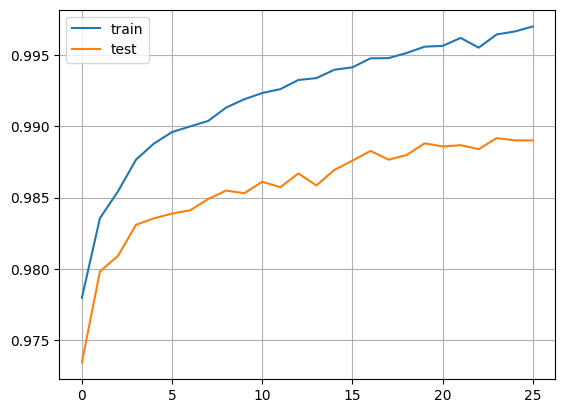

  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipykernel_429/536965784.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))
/tmp/ipykernel_429/536965784.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipykernel_429/536965784.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))
/tmp/ipykernel_429/536965784.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipykernel_429/536965784.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))
/tmp/ipykernel_429/536965784.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipykernel_429/536965784.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))
/tmp/ipykernel_429/536965784.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))


In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HeadClassifier()
optim = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
train(model, optim, loss_fn, device)

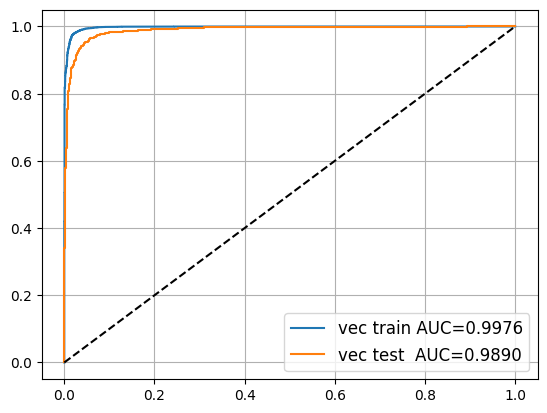

In [81]:
for name, X, y, model in [
    ('vec train', bert_train_ft, y_train, model),
    ('vec test ', bert_test_ft, y_test, model)
]:
    proba = model(torch.tensor(X, dtype=torch.float32)).detach().numpy()
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Как видим обучение дополнительной классификационной головы позволило ещё повысить значение метрики.

Попробуем теперь обучить градиентный бустинг на бертовых признаках.

In [85]:
np.array(labels)

array([1, 1, 0, ..., 1, 1, 1])

In [89]:
# Настроим обучение по фолдам
n_splits = 3
clfs = []
scores = []

X = bert_ft_np
y = np.array(labels)

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_dataset = Pool(data=X_train, label=y_train)
    eval_dataset = Pool(data=X_test, label=y_test)
    
    clf = CatBoostClassifier(
        depth=4,
        iterations=2000,
        learning_rate=0.06,
        loss_function='Logloss',
        eval_metric='AUC',
        
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        
        task_type="CPU",
        thread_count=-1,
        
        early_stopping_rounds=50
    )
    
    clfs.append(clf)
    
    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=500,
        use_best_model=True,
        plot=False)

0:	test: 0.8439072	best: 0.8439072 (0)	total: 69.2ms	remaining: 2m 18s
500:	test: 0.9856054	best: 0.9856054 (500)	total: 7.7s	remaining: 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9872920186
bestIteration = 813

Shrink model to first 814 iterations.
0:	test: 0.8434817	best: 0.8434817 (0)	total: 14.5ms	remaining: 29.1s
500:	test: 0.9882053	best: 0.9882053 (500)	total: 7.33s	remaining: 21.9s
1000:	test: 0.9898272	best: 0.9898278 (985)	total: 14.5s	remaining: 14.5s
1500:	test: 0.9904493	best: 0.9904493 (1500)	total: 21.9s	remaining: 7.28s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9905076426
bestIteration = 1563

Shrink model to first 1564 iterations.
0:	test: 0.8509082	best: 0.8509082 (0)	total: 12.7ms	remaining: 25.3s
500:	test: 0.9846445	best: 0.9846445 (500)	total: 7.31s	remaining: 21.9s
1000:	test: 0.9868098	best: 0.9868098 (1000)	total: 14.6s	remaining: 14.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.987

In [95]:
# Произведем инференс обученных моделей

y_pred = np.zeros((X.shape[0],2))

for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(X)
    
f = lambda x: clf.classes_[x]

In [101]:
(np.array(list(map(f, y_pred.argmax(axis=1)))) == np.array(labels)).mean()

0.9947782282835729

In [98]:
roc_auc_score(list(map(f, y_pred.argmax(axis=1))), labels)

0.9949562023685269

У бустинга получаются результаты не хуже чем у классификационной головы.

### Финальное предсказание

In [103]:
text_test = list(test_data.text.values)

In [105]:
bert_ft_test = None
i = 0
for msg in tqdm(text_test):
    with torch.no_grad():
        features = feature_extractor.get_features(msg)
        if bert_ft_test is None:
            bert_ft_test = features
        else:
            bert_ft_test = torch.cat((bert_ft_test, features), dim=0)
    i += 1
    if i % 500 == 0:
        gc.collect()

  0%|          | 0/4070 [00:00<?, ?it/s]

In [106]:
X_ = np.array(bert_ft_test)
y_pred = np.zeros((X_.shape[0],2))

for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(X_)
    
f = lambda x: clf.classes_[x]

In [108]:
test_data['score'] = list(map(f, y_pred.argmax(axis=1)))

In [123]:
test_data.head()

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,1
1,original message from bitbitch magnesium net p...,1
2,java for managers vince durasoft who just taug...,1
3,there is a youtuber name saiman says,1
4,underpriced issue with high return on equity t...,0


In [124]:
test_data.to_csv('result.csv', index=False)

### Неудачная попытка тюнинга BERT'a

In [15]:
class ModelWithBert(nn.Module):
    
    def __init__(self, hidden_dim=64, max_length=100):
        
        super().__init__()
        self.max_length=max_length
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        # беру версию distil т.к. полная в кагл не влезает
        self.linear1 = nn.Linear(768, hidden_dim)
        self.act = nn.LeakyReLU(0.1)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X, device):
        
        encoded_input = self.tokenizer(X,padding=True,truncation=True, return_tensors='pt')
        encoded_input['input_ids'] = encoded_input['input_ids'].to(device)
        encoded_input['attention_mask'] = encoded_input['attention_mask'].to(device)
        self.model = self.model.to(device)
        output = self.model(**encoded_input)
        encoded_input['input_ids'] = encoded_input['input_ids'].cpu()
        encoded_input['attention_mask'] = encoded_input['attention_mask'].cpu()
        for key in ['last_hidden_state']:
            output[key] = output[key].cpu()
        torch.cuda.empty_cache()
        last_hidden_state = output['last_hidden_state'][:, 0, :]
        return self.sigmoid(self.linear2(
            self.act(self.linear1(last_hidden_state))
        )).cpu()

In [16]:
def train(model, optim, loss_fn, device, batch_size=32, n_epochs=15, texts=texts, labels=labels):
    
    for epoch in tqdm(range(n_epochs)):
        
        combined_lists = list(zip(texts, labels))
        random.shuffle(combined_lists)
        texts, labels = zip(*combined_lists)
        texts = list(texts)
        labels = list(labels)
        
        for i in tqdm(range(len(texts)//batch_size)):
            
            curr_texts = texts[i * batch_size:(i+1) * batch_size]
            curr_labels = labels[i * batch_size: (i+1) * batch_size]
            output = model(curr_texts, device)
            loss = loss_fn(output.squeeze(-1), torch.tensor(curr_labels, dtype= torch.float32))
            loss.backward()
            optim.step()
            optim.zero_grad()
           
        print(f'Epoch = {epoch}')
        for name, X, y, model in [
        ('vec train', texts_train, y_train),
        ('vec test ', texts_test, y_test)
        ]:
            proba = []
            for line in X:
                proba.append(model(line, device))
            auc = roc_auc_score(y, torch.tensor(proba, dtype=torch.float32))
            print(f'    {name}: {auc}')

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
model = ModelWithBert()
optim = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()
train(model, optim, loss_fn, device)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 7086 has 14.74 GiB memory in use. Of the allocated memory 14.60 GiB is allocated by PyTorch, and 14.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Замечание

Попробовать наиболее сильный подход из всех - тюнинг BERT'а под задачу не получилось из-за ограниченных ресурсов, поэтому пока наиболее успешный вариант - использование бертовых признаков для сообщений с обученной классификационной головой. Можно пробовать другие подходы извлечения признаков из текста: например, я хотел попробовать использовать rnn forwad + bacward и конкатенация для извлечения признаков, но не успевал по времени и скорее всего такие признаки будут хуже бертовых, поэтому пробовать не стал. А можно также улучшать модели решающие непосредственно задачу классификации (тюнить параметры и пробовать другие архитектуры сетей).